# Multiple behaviors on subdomains and interface conditions

In this demo, we show how to define a problem containing different subdomains, potentially separated by an interface. In each subdomain, a different elastoplastic behavior is called. In particular, we use a MFront behavior in one domain and a JAX behavior in the second domain, while the interface behavior is written in pure UFL.

We consider a geometry containing a matrix phase and inclusions. Both subdomains will be separated by an elastic interface behavior. In particular, the displacement field is continuous inside both phases, but discontinuous across the interface. To tackle this case, we will build a formulation involving the matrix and the inclusion submeshes with a standard Continuous Galerkin formulation in both of them. The two domains will then be tied by the formulation of an elastic behavior on the interface.

```{image} multimaterials.gif
:align: center
:width: 600px
```

```{seealso}
This demo builds upon the [COMET cohesive zone models tutorials](https://bleyerj.github.io/comet-fenicsx/tours/interfaces/contents.html). While the latter focus on a damageable interface behavior and elastic behavior inside the phases, the present demo assumes an elastic behavior of the interface and different nonlinear plastic behaviors inside both phases. Both approaches can obviously be combined together.
```

```{admonition} Download sources
:class: download

* {Download}`Python script<./multimaterials.py>`
* {Download}`Jupyter notebook<./multimaterials.ipynb>`
* {Download}`Utility module<./utils.py>`
* {Download}`MFront file<./IsotropicPlasticHosfordFlowLinear.mfront>``
```
## Imports

For this demo, you need both `mfront` and `jaxmat` installed. Utility functions regarding submeshes are implemented in the {Download}`utils.py module<./utils.py>`.

In [35]:
import jax

jax.config.update("jax_platform_name", "cpu")
import optimistix as optx
import numpy as np
from mpi4py import MPI
import gmsh
import ufl
from petsc4py import PETSc
from dolfinx import fem, io, mesh, cpp
from dolfinx_materials.quadrature_map import QuadratureMap
from dolfinx_materials.mfront import MFrontMaterial
from dolfinx_materials.jaxmat import JAXMaterial
from dolfinx_materials.solvers import NonlinearMaterialProblem
import jaxmat.materials as jm

from utils import (
    interface_int_entities,
    transfer_meshtags_to_submesh,
)

## Meshing and subdomains

We first create the mesh and define the different tags for identifying physical domains and interfaces.

In [36]:
def create_matrix_inclusion_mesh(L, W, R, hsize):
    comm = MPI.COMM_WORLD

    gmsh.initialize()
    gdim = 2
    model_rank = 0
    if comm.rank == model_rank:
        gmsh.option.setNumber("General.Terminal", 0)  # to disable meshing info
        gmsh.model.add("Model")

        gmsh.model.occ.addRectangle(0.0, 0.0, 0.0, L, W, tag=1)
        gmsh.model.occ.addDisk(0.4, 0.0, 0.0, R, R, tag=2)
        gmsh.model.occ.addDisk(0.6, W, 0.0, R, R, tag=3)
        gmsh.model.occ.fragment([(gdim, 1)], [(gdim, 2), (gdim, 3)], removeObject=True)

        gmsh.model.occ.synchronize()

        gmsh.model.occ.remove([(gdim, 5), (gdim, 4)], recursive=True)

        gmsh.model.occ.synchronize()

        gmsh.option.setNumber("Mesh.CharacteristicLengthMin", hsize)
        gmsh.option.setNumber("Mesh.CharacteristicLengthMax", hsize)

        gmsh.model.addPhysicalGroup(gdim, [1], 1, name="Matrix")
        gmsh.model.addPhysicalGroup(gdim, [2, 3], 2, name="Inclusions")

        gmsh.model.addPhysicalGroup(gdim - 1, [3], 1, name="left")
        gmsh.model.addPhysicalGroup(gdim - 1, [7], 2, name="right")
        gmsh.model.addPhysicalGroup(gdim - 1, [1, 5], 3, name="interface")
        gmsh.model.addPhysicalGroup(gdim - 1, [2, 9, 8, 4, 10, 6], 4, name="sides")
        gmsh.model.mesh.generate(gdim)

    partitioner = cpp.mesh.create_cell_partitioner(mesh.GhostMode.shared_facet)
    mesh_data = io.gmsh.model_to_mesh(
        gmsh.model, MPI.COMM_WORLD, model_rank, gdim=gdim, partitioner=partitioner
    )
    cells = mesh_data.cell_tags
    facets = mesh_data.facet_tags
    domain = mesh_data.mesh
    gmsh.finalize()
    return (domain, cells, facets)

In [37]:
length = 1.0
width = 0.5
radius = 0.25
hsize = 0.01
domain, cells, facets = create_matrix_inclusion_mesh(length, width, radius, hsize)
MATRIX_TAG = 1  # tag of matrix phase
INCL_TAG = 2  # tag of inclusion phase
INT_TAG = 3  # tag of interface
LEFT_TAG = 1  # tag of left boundary
RIGHT_TAG = 2  # tag of right boundary
interface_facets = facets.find(INT_TAG)

tdim = domain.topology.dim
fdim = tdim - 1

### Submesh creation

We define three submeshes: two submeshes (of codim. 0) corresponding to the matrix and inclusion 2D domains and one submesh (of codim. 1) corresponding to the facet restriction on the interface

In [38]:
subdomain2, subdomain2_cell_map, subdomain2_vertex_map, _ = mesh.create_submesh(
    domain, tdim, cells.find(INCL_TAG)
)
subdomain1, subdomain1_cell_map, subdomain1_vertex_map, _ = mesh.create_submesh(
    domain, tdim, cells.find(MATRIX_TAG)
)
interface_mesh, interface_cell_map, _, _ = mesh.create_submesh(
    domain, fdim, interface_facets
)

Now that we have defined submeshes, we need to transfer (facets) meshtags from those defined on the original domain to their subdomain counterpart.

In [39]:
subdomain1_facet_tags, subdomain1_facet_map = transfer_meshtags_to_submesh(
    domain, facets, subdomain1, subdomain1_vertex_map, subdomain1_cell_map
)
subdomain2_facet_tags, subdomain2_facet_map = transfer_meshtags_to_submesh(
    domain, facets, subdomain2, subdomain2_vertex_map, subdomain2_cell_map
)

## Entity map and integration measures

Similarly to the previously mentioned CZM tour, *entity maps* must be defined to link integration of quantities defined on the subdomains.

Before setting up the `entity_maps` list, we need a specific treatment for integrating terms on the interface.
The `interface_int_entities` manually defines the specific integration quantities on the interface. Besides, interface terms seen from one specific subdomain only exist on one side. The helper function defines a consistent ordering such that cells for which `marker[cell] != 0` correspond to the `"+"` restriction (inclusions here), and cells for which `marker[cell] == 0` correspond to the `"-"` restriction (matrix here).

In [40]:
subdomain1.topology.create_connectivity(fdim, tdim)
subdomain2.topology.create_connectivity(fdim, tdim)

# Create a marker to identify cells on the "+" side of the interface
cell_imap = domain.topology.index_map(tdim)
num_cells = cell_imap.size_local + cell_imap.num_ghosts
marker = np.zeros(num_cells)
marker[cells.find(INCL_TAG)] = 1
interface_entities = interface_int_entities(domain, interface_facets, marker)

Finally, the list of entity maps relating both subdomains and the interface to the parent mesh is defined.

In [41]:
entity_maps = [subdomain1_cell_map, subdomain2_cell_map, interface_cell_map]

We are now in position to define the various integration measures. The key point here is that the `dInt` interface measure is defined using prescribed integration entities which have been defined earlier. This is done by passing them to `subdomain_data` as follows.

In [42]:
dx = ufl.Measure("dx", domain=domain, subdomain_data=cells)
ds = ufl.Measure("ds", domain=domain, subdomain_data=facets)
dx_int = ufl.Measure("dx", domain=interface_mesh)
dInt = ufl.Measure(
    "dS",
    domain=domain,
    subdomain_data=[(INT_TAG, interface_entities)],
    subdomain_id=INT_TAG,
)

## Nonlinear behavior formulation
$\newcommand{\bu}{\boldsymbol{u}}
\newcommand{\bv}{\boldsymbol{v}}
\newcommand{\jump}[1]{[\![#1]\!]}$
We now define the relevant function spaces. As hinted before, the unknown $\bu$ will consist of two displacements $(\bu^{(1)},\bu^{(2)})$ respectively belonging to a continuous Lagrange space defined on subdomains 1 and 2. We use a `MixedFunctionSpace` for this, meaning that we will end up with a block system.

In [43]:
def strain(u):
    return ufl.as_vector(
        [
            u[0].dx(0),
            u[1].dx(1),
            0.0,
            1 / np.sqrt(2) * (u[1].dx(0) + u[0].dx(1)),
            0.0,
            0.0,
        ]
    )


V1 = fem.functionspace(subdomain1, ("Lagrange", 1, (tdim,)))
V2 = fem.functionspace(subdomain2, ("Lagrange", 1, (tdim,)))
W = ufl.MixedFunctionSpace(V1, V2)
u1 = fem.Function(V1, name="Displacement")
u2 = fem.Function(V2, name="Displacement")
v1, v2 = ufl.TestFunctions(W)
du1, du2 = ufl.TrialFunctions(W)

### Material laws on subdomains

Second, we define two different materials on the two subdomains. In this example, we use two plastic behaviors with different yield surfaces and hardening laws. In the matrix, a MFront behavior with a Hosford criterion and linear isotropic hardening is used whereas in the stiffer inclusions, we use a `jaxmat` von Mises criterion and Voce nonlinear isotropic hardening.

```{important}
It is perfectly possible to use behaviors with different internal state variables, and even with different gradients/fluxes etc. They are really independent from each other and will only be combined by summing their contribution to the resulting weak form.
```

In [44]:
material1 = MFrontMaterial(
    "src/libBehaviour.so",
    "IsotropicPlasticHosfordFlowLinear",
    material_properties={
        "young_modulus": 70e3,
        "poisson_ratio": 0.3,
        "R0": 200.0,
        "hardening_slope": 10,
    },
)

elasticity = jm.LinearElasticIsotropic(E=90e3, nu=0.25)
yield_stress = jm.VoceHardening(sig0=200.0, b=10.0, sigu=300.0)
behavior = jm.vonMisesIsotropicHardening(
    elasticity=elasticity, yield_stress=yield_stress
)
material2 = JAXMaterial(behavior)

As a result, we define two different `QuadratureMap` defined on both subdomains. Note that the registered gradients involve the two different displacements `u1` and `u2` respectively. We simply need to pay attention to the names used by both implementations for gradients, fluxes and state variables. Note that when assembling mixed forms it is more convenient that integration measures are defined on the similar parent domain (the full mesh) and to pass the entity maps when compiling the forms. We thus redefine the `qmap` measures metadata accordingly. Finally, we define the contributions of both subdomains to the total residual form.

In [45]:
deg_quad = 1
qmap1 = QuadratureMap(subdomain1, deg_quad, material1)
qmap1.register_gradient("Strain", strain(u1))
qmap1.dx = qmap1.dx(domain=domain, subdomain_data=cells)
sig1 = qmap1.fluxes["Stress"]

qmap2 = QuadratureMap(subdomain2, deg_quad, material2)
qmap2.register_gradient("strain", strain(u2))
qmap2.dx = qmap2.dx(domain=domain, subdomain_data=cells)
sig2 = qmap2.fluxes["stress"]

Res_matrix = ufl.dot(sig1, strain(v1)) * qmap1.dx(1)
Res_inclusions = ufl.dot(sig2, strain(v2)) * qmap2.dx(2)

### Interface behavior

As regards the elastic interface of stiffness $K$, its contribution to the total residual is given by:

$$
\int_{\Gamma} K\jump{\bu}\cdot\jump{\bv}\,\text{d}S
$$

where we define the displacement $\jump{\bu} = \bu^{(2)} - \bu^{(1)}$ with $(1)$ denoting subdomain 1 (the matrix) and $(2)$ denoting subdomain 2 (the inclusions). Note that we need to restrict quantities since we work with a facet measure on the interface $\Gamma$. Although only one side exist for each subdomain, cells of a given subdomain from one side have been mapped to the other side, as discussed before. As a result, it does not really matter which side is used here. For consistency, we use the the `"+"` side for subdomain 1 and the `"-"` side for subdomain 2.

In [46]:
def jump(u1, u2):
    return u2("+") - u1("-")


K = fem.Constant(domain, 1e5)

Res_interface = K * ufl.dot(jump(u1, u2), jump(v1, v2)) * dInt

### Total residual and jacobian

Finally, the total residual is the sum of all three residuals. Since we work with a `MixedFunctionSpace`, we use `ufl.extract_blocks` to extract the blocks corresponding to both `u1` and `u2`. We then compute the corresponding Jacobian with both `qmap.derivative` in the corresponding trial functions. Both the residual and tangent blocked forms are compiled by passing the `entity_maps` to `fem.form`.

In [47]:
Res = Res_matrix + Res_inclusions + Res_interface
Res_blocked_compiled = fem.form(ufl.extract_blocks(Res), entity_maps=entity_maps)

Jac = qmap1.derivative(Res, u1, du1) + qmap2.derivative(Res, u2, du2)
Jac_blocked_compiled = fem.form(ufl.extract_blocks(Jac), entity_maps=entity_maps)

### Boundary conditions

We apply an imposed displacement on the right boundary and fix the left boundary. We use a virtual test field with unit value on the boundary to compute the consistent reaction force, see [](https://bleyerj.github.io/comet-fenicsx/tips/computing_reactions/computing_reactions.html).

In [48]:
Uimp = fem.Constant(domain, (1.0, 0.0))
left_dofs = fem.locate_dofs_topological(V1, fdim, subdomain1_facet_tags.find(1))
right_dofs = fem.locate_dofs_topological(V1, fdim, subdomain1_facet_tags.find(2))

bcs = [
    fem.dirichletbc(np.zeros((tdim,)), left_dofs, V1),
    fem.dirichletbc(Uimp, right_dofs, V1),
]

v_reac1 = fem.Function(V1)
fem.set_bc(v_reac1.x.array, bcs)
v_reac2 = fem.Function(V2)
fem.set_bc(v_reac2.x.array, bcs)
virtual_work_form = fem.form(
    ufl.replace(Res, {v1: v_reac1, v2: v_reac2}),
    entity_maps=entity_maps,
)

## Resolution

Next, we define the `NonlinearMaterialProblem` by passing the list of `QuadratureMap` objects and a list of functions corresponding to the blocked solution. We then define a classical Newton solver.

In [49]:
petsc_options = {
    "snes_type": "newtonls",
    "snes_linesearch_type": "none",
    "snes_atol": 1e-6,
    "snes_rtol": 1e-6,
    "snes_monitor": None,
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
}
problem = NonlinearMaterialProblem(
    [qmap1, qmap2],
    Res_blocked_compiled,
    [u1, u2],
    bcs=bcs,
    J=Jac_blocked_compiled,
    petsc_options_prefix="multimaterials",
    petsc_options=petsc_options,
)

### Time-stepping

Upon time-stepping, post-processing steps are needed. Fields associated with both domains are stored in their own file, since they do not share the same mesh.

In [50]:
N = 30
Exx = np.linspace(0, 15e-3, N + 1)

p1 = qmap1.project_on("EquivalentPlasticStrain", ("DG", 0), entity_maps=entity_maps)
p1.name = "PlasticStrain1"
p2 = qmap2.project_on("p", ("DG", 0), entity_maps=entity_maps)
p2.name = "PlasticStrain2"


file1 = io.VTXWriter(domain.comm, f"multimaterials_domain1.bp", output=[u1, p1])
file1.write(0)
file2 = io.VTXWriter(domain.comm, f"multimaterials_domain2.bp", output=[u2, p2])
file2.write(0)

Force = np.zeros_like(Exx)
for i, exx in enumerate(Exx[1:]):
    Uimp.value[0] = exx * length

    problem.solve()
    assert problem.solver.getConvergedReason()
    print(
        f"Increment {i} converged in {problem.solver.getIterationNumber()} iterations."
    )

    qmap1.project_on(
        "EquivalentPlasticStrain", ("DG", 0), fun=p1, entity_maps=entity_maps
    )
    qmap2.project_on("p", ("DG", 0), fun=p2, entity_maps=entity_maps)

    file1.write(i + 1)
    file2.write(i + 1)

    Force[i + 1] = fem.assemble_scalar(virtual_work_form)

file1.close()
file2.close()

  0 SNES Function norm 3.867274333583e+02
  1 SNES Function norm 1.005760903704e-12
Increment 0 converged in 1 iterations.
  0 SNES Function norm 3.867274333583e+02
  1 SNES Function norm 1.209760665976e-12
Increment 1 converged in 1 iterations.
  0 SNES Function norm 3.867274333583e+02
  1 SNES Function norm 2.365480185217e-01
  2 SNES Function norm 6.653234555293e-02
  3 SNES Function norm 6.563246014305e-03
  4 SNES Function norm 1.098762637903e-05
Increment 2 converged in 4 iterations.
  0 SNES Function norm 3.867274333583e+02
  1 SNES Function norm 1.619294359343e+00
  2 SNES Function norm 3.118312572982e+00
  3 SNES Function norm 1.503417474619e-01
  4 SNES Function norm 1.557658234991e-02
  5 SNES Function norm 3.250964824946e-05
Increment 3 converged in 5 iterations.
  0 SNES Function norm 3.867274333583e+02
  1 SNES Function norm 1.390828437609e+00
  2 SNES Function norm 2.936427369176e-01
  3 SNES Function norm 5.419271866392e-02
  4 SNES Function norm 1.341608239467e-03
  5 

## Results

We finally plot the resulting load-displacement curve.

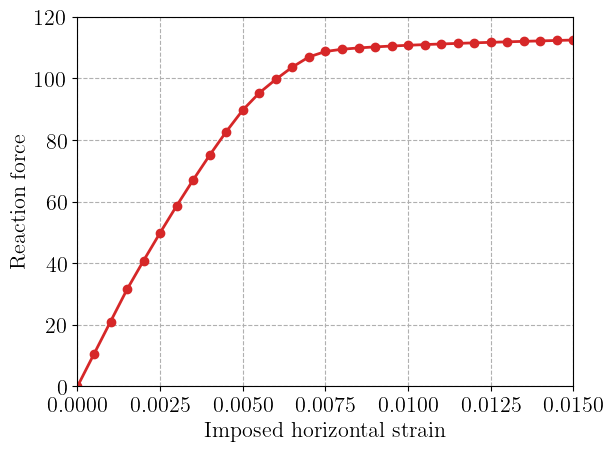

In [51]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(Exx, Force, "-oC3")
plt.xlabel("Imposed horizontal strain")
plt.ylabel("Reaction force")
plt.show()